# **Part A**
Count / Frequency based Naive Bayes Classifier

In [11]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score
)

# =======================================================
# TODO: Students must implement the following steps:
# 2. Complete the predict method in NaiveBayesClassifier (2 TODOs for log probability accumulation and final argmax).
# 3. Complete the data loading calls in Section 2.
# 4. Initialize CountVectorizer with proper parameters in Section 3a.
# 5. Complete the feature transformation (fit_transform and transform) in Section 3a.
# 6. Initialize and fit the custom nb_model in Section 3b.
# 7. Use the fitted nb_model to generate predictions in Section 4.
# =======================================================


# Data loading function (DO NOT CHANGE)
def load_pubmed_rct_file(filepath):
    """
    Reads a .txt file from the PubMed 20k RCT dataset.
    Returns a DataFrame with 'label' and 'sentence'.
    """
    labels, sentences = [], []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line or '\t' not in line:
                continue
            label, sent = line.split('\t', maxsplit=1)
            labels.append(label)
            sentences.append(sent)
    return pd.DataFrame({'label': labels, 'sentence': sentences})


# -------------------------------------------------
# 1. NaiveBayesClassifier – fit() & predict()
# -------------------------------------------------
class NaiveBayesClassifier:
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        self.class_priors = {}
        self.feature_log_probs = {}
        self.classes = None
        self.vocabulary_size = 0

    def fit(self, X_counts, y):
        y_array = y.to_numpy()
        self.classes = np.unique(y_array)
        self.vocabulary_size = X_counts.shape[1]
        n_total = y_array.shape[0]

        for c in self.classes:
            X_c = X_counts[y_array == c]

            # Log prior: log(P(c))
            self.class_priors[c] = np.log(X_c.shape[0] / n_total)

            feature_sum = X_c.sum(axis=0).A1
            total_mass = np.sum(feature_sum)

            # Laplace smoothing
            numerator   = feature_sum + self.alpha
            denominator = total_mass + self.alpha * self.vocabulary_size

            # Log likelihood: log(P(w|c))
            self.feature_log_probs[c] = np.log(numerator / denominator)

    def predict(self, X_counts):
        y_pred = []
        for i in range(X_counts.shape[0]):
            scores = {}
            x_i = X_counts.getrow(i)

            for c in self.classes:
                log_prob = self.class_priors[c]
                log_likelihoods = self.feature_log_probs[c]

                # Sum over non-zero features: count(w) * log(P(w|c))
                log_prob += sum(
                    x_i.data[j] * log_likelihoods[x_i.indices[j]]
                    for j in range(len(x_i.indices))
                )
                scores[c] = log_prob

            predicted_class = max(scores, key=scores.get)
            y_pred.append(predicted_class)

        return np.array(y_pred)

In [12]:
# -------------------------------------------------
# 2. Load data (remove placeholder lines)
# -------------------------------------------------
dir_path = './'
try:
    train_df = load_pubmed_rct_file(os.path.join(dir_path, 'train.txt'))
    dev_df   = load_pubmed_rct_file(os.path.join(dir_path, 'dev.txt'))
    test_df  = load_pubmed_rct_file(os.path.join(dir_path, 'test.txt'))

    print(f"Train samples: {len(train_df)}")
    print(f"Dev   samples: {len(dev_df)}")
    print(f"Test  samples: {len(test_df)}")

    X_train, y_train = train_df['sentence'], train_df['label']
    X_dev,   y_dev   = dev_df['sentence'],   dev_df['label']
    X_test,  y_test  = test_df['sentence'],  test_df['label']
    target_names = sorted(y_train.unique())
    print(f"Classes: {target_names}")

except FileNotFoundError as e:
    print(f"Error: Dataset file not found. Please ensure the files are uploaded.")
    X_train, y_train = pd.Series([]), pd.Series([])
    X_test, y_test = pd.Series([]), pd.Series([])
    target_names = []

Train samples: 180040
Dev   samples: 30212
Test  samples: 30135
Classes: ['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS']


In [13]:
# -------------------------------------------------
# 3. CountVectorizer + custom NB training
# -------------------------------------------------
if X_train is not None and len(X_train) > 0:

    count_vectorizer = CountVectorizer(
        lowercase=True,
        strip_accents='unicode',
        stop_words='english',
        ngram_range=(1, 1),   # unigrams
        min_df=5               # ignore very rare words
    )

    print("Fitting Count Vectorizer and transforming training data...")
    X_train_counts = count_vectorizer.fit_transform(X_train)
    print(f"Vocabulary size: {X_train_counts.shape[1]}")

    print("Transforming test data...")
    X_test_counts = count_vectorizer.transform(X_test)

    print("\nTraining the Custom Naive Bayes Classifier (from scratch)...")
    nb_model = NaiveBayesClassifier(alpha=1.0)
    nb_model.fit(X_train_counts, y_train)
    print("Training complete.")
else:
    print("Skipping feature extraction and training: Training data is empty or not loaded.")

Fitting Count Vectorizer and transforming training data...
Vocabulary size: 22722
Transforming test data...

Training the Custom Naive Bayes Classifier (from scratch)...
Training complete.


In [14]:
# -------------------------------------------------
# 4. Prediction & evaluation
# -------------------------------------------------
print("\n===== Test Set Evaluation (Custom Count-Based Naive Bayes) =====")
y_test_pred = nb_model.predict(X_test_counts)

if y_test_pred is not None:
    print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
    print(classification_report(y_test, y_test_pred, target_names=target_names))
    test_f1 = f1_score(y_test, y_test_pred, average='macro')
    print(f"Macro-averaged F1 score: {test_f1:.4f}")
else:
    print("Prediction step failed or incomplete.")


===== Test Set Evaluation (Custom Count-Based Naive Bayes) =====
Accuracy: 0.7337
              precision    recall  f1-score   support

  BACKGROUND       0.52      0.56      0.54      3621
 CONCLUSIONS       0.60      0.66      0.63      4571
     METHODS       0.82      0.84      0.83      9897
   OBJECTIVE       0.50      0.51      0.51      2333
     RESULTS       0.87      0.78      0.82      9713

    accuracy                           0.73     30135
   macro avg       0.66      0.67      0.67     30135
weighted avg       0.74      0.73      0.74     30135

Macro-averaged F1 score: 0.6655


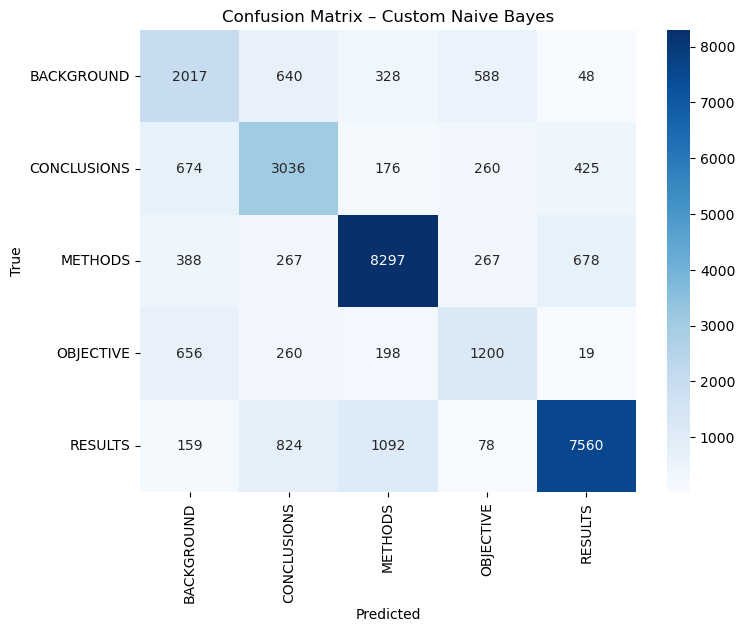

In [15]:
# -------------------------------------------------
# 5. Confusion matrix heatmap
# -------------------------------------------------
if y_test_pred is not None:
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix – Custom Naive Bayes')
    plt.show()

# **Part B**
TF-IDF score based Classifier

In [16]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score
)

# =======================================================
# TODO: Implement the following steps:
# 1. Define the initial `pipeline` combining TfidfVectorizer and MultinomialNB with default parameters.
# 2. Train the initial pipeline on the training data (X_train, y_train).
# 3. Predict and evaluate the performance of the initial model on the test data (X_test, y_test).
# 4. Define the `param_grid` for hyperparameter tuning.
# 5. Initialize `GridSearchCV` using the pipeline, parameter grid, and appropriate cross-validation settings.
# 6. Fit the Grid Search object using the development data (X_dev, y_dev).
# 7. Print the `best_params_` and `best_score_` found by the grid search.
# =======================================================


# -------------------------------------------------
# 1. Pipeline (TfidfVectorizer + MultinomialNB)
# -------------------------------------------------
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        lowercase=True,
        strip_accents='unicode',
        stop_words='english',
        ngram_range=(1, 1),
        min_df=5
    )),
    ('nb', MultinomialNB(alpha=1.0))
])

print("Training initial Naive Bayes pipeline...")
pipeline.fit(X_train, y_train)
print("Training complete.")


# -------------------------------------------------
# 2. Initial model evaluation on test set
# -------------------------------------------------
print("\n=== Test Set Evaluation (Initial Sklearn Model) ===")
y_test_pred = pipeline.predict(X_test)

if y_test_pred is not None:
    print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
    print(classification_report(y_test, y_test_pred, target_names=target_names))
    print(f"Macro-averaged F1 score: {f1_score(y_test, y_test_pred, average='macro'):.4f}")
else:
    print("Initial model evaluation skipped: Predictions not available.")
    
# -------------------------------------------------
# 3. Hyper-parameter grid & GridSearchCV
# -------------------------------------------------
param_grid = {
    'tfidf__ngram_range': [(1,1), (1,2)],   # unigrams vs. unigrams+bigrams
    'nb__alpha': [0.1, 0.5, 1.0, 2.0]       # smoothing
}

grid = GridSearchCV(pipeline, param_grid, cv=3, scoring='f1_macro')

print("\nStarting Hyperparameter Tuning on Development Set...")
grid.fit(X_dev, y_dev)
print("Grid search complete.")

if grid is not None and hasattr(grid, 'best_params_'):
    print("Best Parameters:", grid.best_params_)
    print("Best Cross-Validation Score (F1 Macro):", grid.best_score_)
else:
    print("Hyperparameter tuning skipped: Grid Search object not initialized or fitted.")

Training initial Naive Bayes pipeline...
Training complete.

=== Test Set Evaluation (Initial Sklearn Model) ===
Accuracy: 0.7239
              precision    recall  f1-score   support

  BACKGROUND       0.58      0.46      0.51      3621
 CONCLUSIONS       0.61      0.61      0.61      4571
     METHODS       0.74      0.87      0.80      9897
   OBJECTIVE       0.70      0.23      0.35      2333
     RESULTS       0.80      0.84      0.82      9713

    accuracy                           0.72     30135
   macro avg       0.69      0.60      0.62     30135
weighted avg       0.72      0.72      0.71     30135

Macro-averaged F1 score: 0.6184

Starting Hyperparameter Tuning on Development Set...
Grid search complete.
Best Parameters: {'nb__alpha': 0.1, 'tfidf__ngram_range': (1, 2)}
Best Cross-Validation Score (F1 Macro): 0.6302879153606775


# **Part C**
Bayes Optimal Classifier

Part C Draft

In [20]:

from scipy.special import softmax  # <-- ADDED: Fixes NameError

# =======================================================
# TODO: Implement the following steps:
# 1. Train all five hypotheses on the sampled training data.
# 2. Compute the Posterior Weights P(h_i | D) using a validation split.
# 3. Fit the VotingClassifier using the sampled training data.
# 4. Make final predictions and evaluate the BOC performance on the test data.
# =======================================================

# Dynamic Data Sampling (DO NOT CHANGE)
BASE_SAMPLE_SIZE = 10000

# Prompt the user for their full SRN
FULL_SRN = input("Please enter your full SRN (e.g., PES2UG24CS801): ")

try:
    if len(FULL_SRN) >= 3:
        srn_suffix_str = FULL_SRN[-3:]
        srn_value = int(srn_suffix_str)
    else:
        raise ValueError("SRN too short.")
except (ValueError, IndexError, TypeError):
    print("WARNING: SRN input failed or format is incorrect. Using 10000.")
    srn_value = 0

SAMPLE_SIZE = BASE_SAMPLE_SIZE + srn_value
print(f"Using dynamic sample size: {SAMPLE_SIZE}")

# Placeholder initialization in case data wasn't loaded
if 'X_train' not in locals() or len(X_train) == 0:
    print("Warning: Training data not found. Using small placeholder data.")
    X_train = pd.Series(["sample text one"] * 11000)
    y_train = pd.Series(["BACKGROUND"] * 5000 + ["METHODS"] * 6000)
    X_test = pd.Series(["test text one", "test text two"])
    y_test = pd.Series(["BACKGROUND", "METHODS"])
    target_names = ["BACKGROUND", "CONCLUSIONS", "METHODS", "OBJECTIVE", "RESULTS"]

effective_sample_size = min(SAMPLE_SIZE, len(X_train))
X_train_sampled = X_train[:effective_sample_size]
y_train_sampled = y_train[:effective_sample_size]
print(f"Actual sampled training set size used: {effective_sample_size}")

# Base TF-IDF parameters (DO NOT CHANGE)
tfidf_params = {
    'lowercase': True,
    'strip_accents': 'unicode',
    'stop_words': 'english',
    'ngram_range': (1, 1),
    'min_df': 5
}

# Define the five diverse hypotheses/pipelines (DO NOT CHANGE)
h1_nb = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', MultinomialNB(alpha=1.0, fit_prior=False))
])

h2_lr = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', LogisticRegression(solver='liblinear', multi_class='auto', max_iter=1000, random_state=42))
])

h3_rf = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', CalibratedClassifierCV(
        RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1), cv=3, method='isotonic'
    ))
])

h4_dt = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', CalibratedClassifierCV(
        DecisionTreeClassifier(max_depth=10, random_state=42), cv=3, method='isotonic'
    ))
])

h5_knn = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('clf', CalibratedClassifierCV(
        KNeighborsClassifier(n_neighbors=5, n_jobs=-1), cv=3, method='isotonic'
    ))
])

hypotheses = [h1_nb, h2_lr, h3_rf, h4_dt, h5_knn]
hypothesis_names = ['NaiveBayes', 'LogisticRegression', 'RandomForest', 'DecisionTree', 'KNN']

# -------------------------------------------------
# 1. Train the five diverse hypotheses on sampled data
# -------------------------------------------------
print("\nTraining all base models...")
for h in hypotheses:
    h.fit(X_train_sampled, y_train_sampled)
print("All base models trained.")

# -------------------------------------------------
# 2. Posterior weight calculation P(h_i | D)
# -------------------------------------------------
X_sub, X_val, y_sub, y_val = train_test_split(
    X_train_sampled, y_train_sampled, test_size=0.2, random_state=42, stratify=y_train_sampled
)

# Train on sub-set
for h in hypotheses:
    h.fit(X_sub, y_sub)

# Compute average log-likelihood on validation
classes = sorted(np.unique(y_train_sampled))
label_to_idx = {lbl: i for i, lbl in enumerate(classes)}
y_val_idx = y_val.map(label_to_idx).values

log_likelihoods = []
for h in hypotheses:
    probas = h.predict_proba(X_val)
    ll = np.mean(np.log(probas[np.arange(len(y_val_idx)), y_val_idx] + 1e-10))
    log_likelihoods.append(ll)

# Equal priors: log(1/5)
log_prior = np.log(1.0 / len(hypotheses))
log_posteriors = np.array(log_likelihoods) + log_prior
posterior_weights = softmax(log_posteriors)  # NOW WORKS!
print("Posterior weights:", posterior_weights)

# -------------------------------------------------
# 3. Refit all hypotheses on the *full* sampled data
# -------------------------------------------------
for h in hypotheses:
    h.fit(X_train_sampled, y_train_sampled)

# -------------------------------------------------
# 4. Build & fit the soft-voting BOC
# -------------------------------------------------
estimators = list(zip(hypothesis_names, hypotheses))

boc_soft_voter = VotingClassifier(
    estimators=estimators,
    voting='soft',
    weights=posterior_weights,
    n_jobs=-1
)

print("\nFitting the VotingClassifier (BOC approximation)...")
boc_soft_voter.fit(X_train_sampled, y_train_sampled)
print("Fitting complete.")

# -------------------------------------------------
# 5. Final prediction & full evaluation
# -------------------------------------------------
print("\nPredicting on test set...")
y_pred = boc_soft_voter.predict(X_test)

print("\n=== Final Evaluation: Bayes Optimal Classifier (Soft Voting) ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred, target_names=target_names))
print(f"Macro-averaged F1 score: {f1_score(y_test, y_pred, average='macro'):.4f}")

# Confusion matrix heatmap
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix – Bayes Optimal Classifier')
plt.show()

Please enter your full SRN (e.g., PES2UG24CS801): PES2UG24CS801
Using dynamic sample size: 10801
Actual sampled training set size used: 10801

Training all base models...
All base models trained.
Posterior weights: [0.22601025 0.24344267 0.22266562 0.16659656 0.1412849 ]

Fitting the VotingClassifier (BOC approximation)...
Fitting complete.

Predicting on test set...

=== Final Evaluation: Bayes Optimal Classifier (Soft Voting) ===
Accuracy: 0.6990
              precision    recall  f1-score   support

  BACKGROUND       0.59      0.32      0.41      3621
 CONCLUSIONS       0.59      0.53      0.56      4571
     METHODS       0.68      0.89      0.77      9897
   OBJECTIVE       0.69      0.34      0.45      2333
     RESULTS       0.78      0.81      0.80      9713

    accuracy                           0.70     30135
   macro avg       0.67      0.58      0.60     30135
weighted avg       0.69      0.70      0.68     30135

Macro-averaged F1 score: 0.5994
